In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/food_orders_new_delhi (1).csv')
df.shape

(1000, 12)

In [ ]:
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [ ]:
df.describe()

,Order ID,Order Value,Delivery Fee,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,1053.969000,28.620000,126.99000,29.832000,28.300000
std,288.819436,530.975339,16.958278,43.06405,11.627165,49.614228
min,1.000000,104.000000,0.000000,50.00000,10.000000,0.000000
25%,250.750000,597.750000,20.000000,90.00000,20.000000,0.000000
50%,500.500000,1038.500000,30.000000,127.00000,30.000000,0.000000
75%,750.250000,1494.000000,40.000000,164.00000,40.000000,50.000000
max,1000.000000,1995.000000,50.000000,200.00000,50.000000,150.000000


In [ ]:
# standardize column names
df.columns = df.columns.str.lower().str.replace(' ','_')
df.columns

Index(['order_id', 'customer_id', 'restaurant_id', 'order_date_and_time',
       'delivery_date_and_time', 'order_value', 'delivery_fee',
       'payment_method', 'discounts_and_offers', 'commission_fee',
       'payment_processing_fee', 'refunds/chargebacks'],
      dtype='object')

Data Preprocessing

In [ ]:
# convert [Order Date and Time] and [Delivery Date and Time] to datetime
df['order_date_and_time'] = pd.to_datetime(df['order_date_and_time'])
df['delivery_date_and_time'] = pd.to_datetime(df['delivery_date_and_time'])

In [ ]:
df.dtypes

,0
order_id,int64
customer_id,object
restaurant_id,object
order_date_and_time,datetime64[ns]
delivery_date_and_time,datetime64[ns]
order_value,int64
delivery_fee,int64
payment_method,object
discounts_and_offers,object
commission_fee,int64


In [ ]:
# Costs = Delivery Fee + Payment Processing Fee + Discount Amount, where total discount includes ['discounts and offers'] & ['refunds/chargebacks']

# Check ['discounts and offer'] column
df['discounts_and_offers'].value_counts()

,count
discounts_and_offers,
10%,233
50 off Promo,201
15% New User,198
5% on App,183


In [ ]:
# extract percentage discounts
def extract_percentage(offer):
    offer = str(offer)
    if '%' in offer:
        return int(str(offer).split('%')[0])
    return 0

# extract cash discounts
def extract_cash(offer):
    offer = str(offer)
    words = offer.split()
    for word in words:
        if word.isdigit():
            return int(word)
    return 0

# Create new columns
df['discount_pct'] = df['discounts_and_offers'].apply(extract_percentage)
df['discount_cash'] = df['discounts_and_offers'].apply(extract_cash)

df[['discount_pct', 'discount_cash']]

,discount_pct,discount_cash
0,5,0
1,10,0
2,15,0
3,0,0
4,0,50
...,...,...
995,5,0
996,0,0
997,0,0
998,15,0


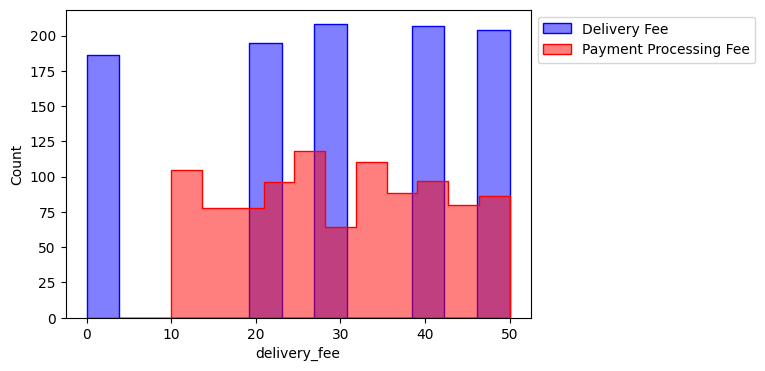

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['delivery_fee'], kde=False, color='blue', label='Delivery Fee', alpha=0.5, element="step")
sns.histplot(df['payment_processing_fee'], kde=False, color='red', label='Payment Processing Fee', alpha=0.5, element="step")

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [ ]:
# cost = (delivery fee + payment processing fee + discounts_cash) * (discounts_pct)
df['cost'] = (df['delivery_fee'] + df['payment_processing_fee'] + df['discount_cash']) * (100 + df['discount_pct']) / 100
df.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds/chargebacks,discount_pct,discount_cash,cost
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5,0,49.35
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10,0,69.30
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,15,0,86.25
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0,0,0,77.00
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,0,50,130.00


In [ ]:
# revenue = commission fee
df['revenue'] = df['commission_fee']

# profits
df['profits'] = df['revenue'] - df['cost']
df['have_profits'] = df['profits'].apply(lambda x: 1 if x > 0 else 0)

df.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds/chargebacks,discount_pct,discount_cash,cost,revenue,profits,have_profits
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5,0,49.35,150,100.65,1
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10,0,69.30,198,128.70,1
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,15,0,86.25,195,108.75,1
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0,0,0,77.00,146,69.00,1
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,0,50,130.00,130,0.00,0


Explotary Data Analysis

In [ ]:
# offers vs cost and profit
df[['cost', 'discounts_and_offers', 'profits']].head()

,cost,discounts_and_offers,profits
0,49.35,5% on App,100.65
1,69.30,10%,128.70
2,86.25,15% New User,108.75
3,77.00,NaN,69.00
4,130.00,50 off Promo,0.00


In [ ]:
df['cost_from_offers'] = df['cost'] - df['payment_processing_fee'] - df['delivery_fee']
df.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds/chargebacks,discount_pct,discount_cash,cost,revenue,profits,have_profits,cost_from_offers
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5,0,49.35,150,100.65,1,2.35
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10,0,69.30,198,128.70,1,6.30
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,15,0,86.25,195,108.75,1,11.25
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0,0,0,77.00,146,69.00,1,0.00
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,0,50,130.00,130,0.00,0,50.00


<Axes: xlabel='discounts_and_offers'>

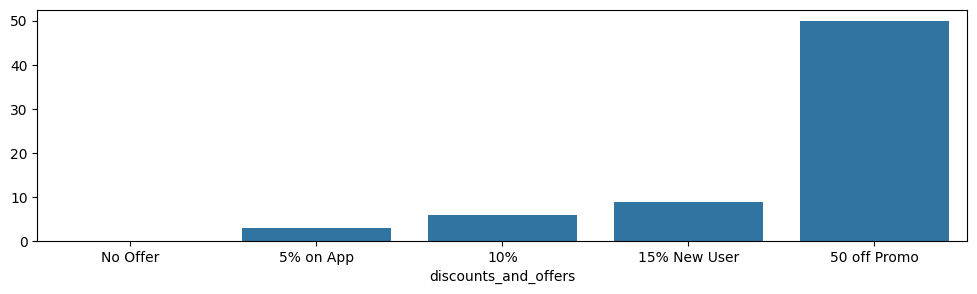

In [ ]:
df['discounts_and_offers'] = df['discounts_and_offers'].fillna('No Offer')

plt.figure(figsize=(12, 3))

# avg cost per offer
avg_cost = df.groupby('discounts_and_offers')['cost_from_offers'].mean().sort_values()
sns.barplot(x=avg_cost.index, y=avg_cost.values)

([0, 1, 2, 3, 4],
 [Text(0, 0, '50 off Promo'),
  Text(1, 0, '15% New User'),
  Text(2, 0, '10%'),
  Text(3, 0, '5% on App'),
  Text(4, 0, 'No Offer')])

<Figure size 1200x300 with 0 Axes>

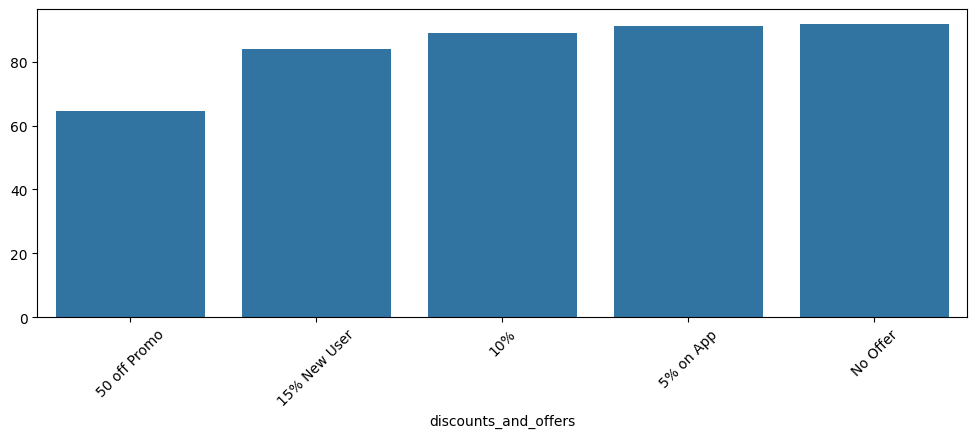

In [ ]:
#Cash discount is the most expensive but we have to include profits to complete the story
plt.figure(figsize=(12, 3))

profit_counts = df.groupby('discounts_and_offers')['have_profits'].sum()
total_counts = df['discounts_and_offers'].value_counts()
profit_percentage = (profit_counts / total_counts * 100).sort_values()

# Plot the percentage of profitable offers
plt.figure(figsize=(12, 4))
sns.barplot(x=profit_percentage.index, y=profit_percentage.values)
plt.xticks(rotation=45)

In [ ]:
#Percentage of Profitable orders is the lowest for cash discounts as well
df.customer_id.value_counts()

,count
customer_id,
C7938,3
C7949,3
C6486,2
C7190,2
C6977,2
...,...
C8509,1
C4854,1
C3491,1


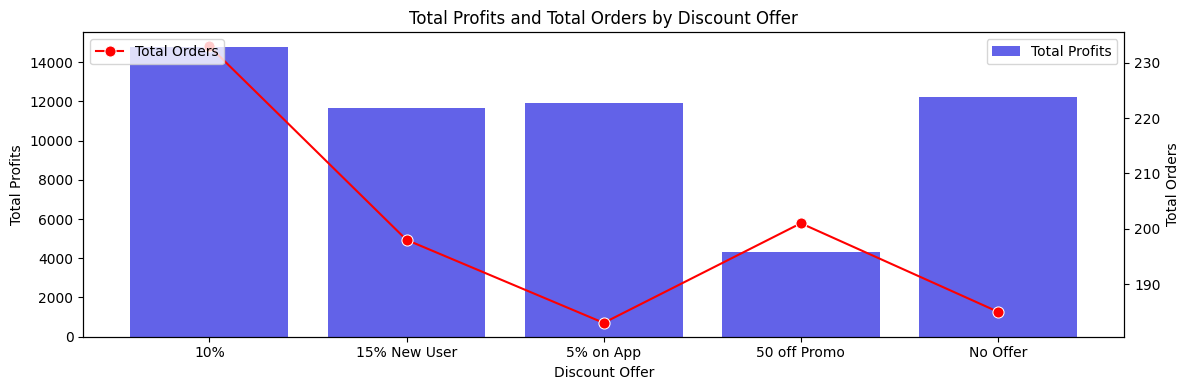

In [ ]:
profits_orders = df.groupby('discounts_and_offers').agg({'profits': 'sum', 'cost': 'count'}).reset_index()
profits_orders.rename(columns={'cost': 'total_orders'}, inplace=True)

plt.figure(figsize=(12, 4))

ax1 = sns.barplot(x='discounts_and_offers', y='profits', data=profits_orders, color='blue', alpha=0.7, label='Total Profits')
ax2 = ax1.twinx()
sns.lineplot(x='discounts_and_offers', y='total_orders', data=profits_orders, color='red', marker='o', markersize=8, ax=ax2, label='Total Orders')

ax1.set_title('Total Profits and Total Orders by Discount Offer')
ax1.set_xlabel('Discount Offer')
ax1.set_ylabel('Total Profits')
ax2.set_ylabel('Total Orders')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


From here we can see the profits and orders that each discount created

Time series analysis
Let's explore a few time series analyses: (a) seasonality effects, (b) weekends/weekdays trends, (c) effects of different times of day - breakfast, lunch, dinner, supper. This would help guide our dynamic pricing decision and discount/voucher drops

In [ ]:
df.head()

,order_id,customer_id,restaurant_id,order_date_and_time,delivery_date_and_time,order_value,delivery_fee,payment_method,discounts_and_offers,commission_fee,payment_processing_fee,refunds/chargebacks,discount_pct,discount_cash,cost,revenue,profits,have_profits,cost_from_offers
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0,5,0,49.35,150,100.65,1,2.35
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0,10,0,69.30,198,128.70,1,6.30
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0,15,0,86.25,195,108.75,1,11.25
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,No Offer,146,27,0,0,0,77.00,146,69.00,1,0.00
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0,0,50,130.00,130,0.00,0,50.00


In [ ]:
df['order_date'] = df['order_date_and_time'].dt.date
df['order_time'] = df['order_date_and_time'].dt.time
df['delivery_date'] = df['delivery_date_and_time'].dt.date
df['delivery_time'] = df['delivery_date_and_time'].dt.time

df.set_index('order_date', inplace=True) # set order date as index for TSA
df.index = pd.to_datetime(df.index)

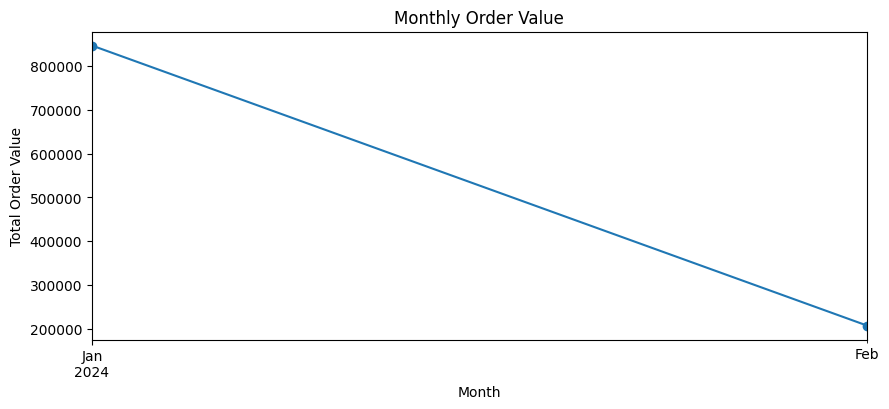

In [ ]:
# 1. seasonality effects
plt.figure(figsize=(10,4))
df['order_value'].resample('M').sum().plot(marker='o', linestyle='-')
plt.title('Monthly Order Value')
plt.xlabel('Month')
plt.ylabel('Total Order Value')
plt.show()

Text(0, 0.5, 'Number of Orders')

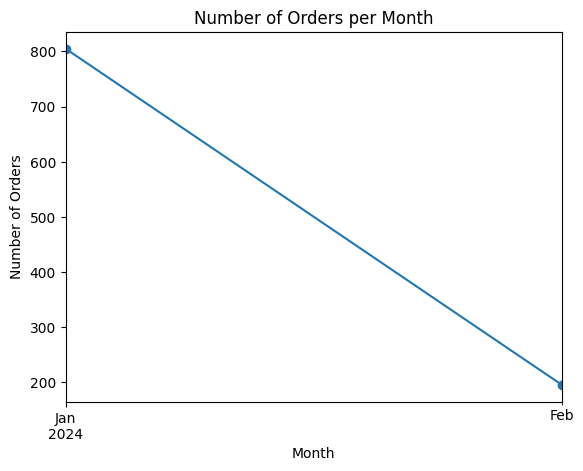

In [ ]:
orders_per_month = df.resample('M').size()
orders_per_month.plot(marker='o', linestyle='-')
plt.title('Number of Orders per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

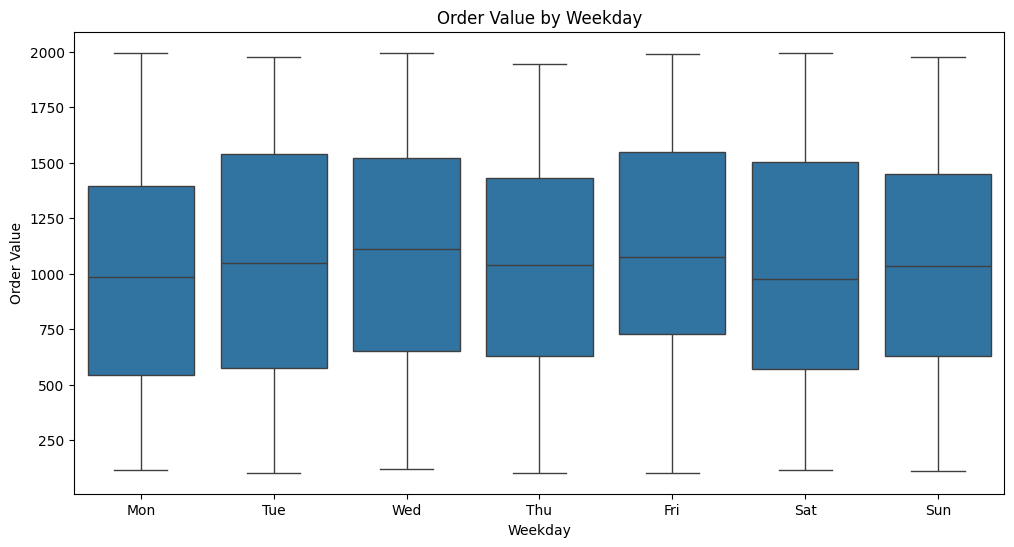

In [ ]:
# 2. effects of weekends and weekdays
plt.figure(figsize=(12, 6))
df['weekday'] = df.index.dayofweek  # Monday=0, Sunday=6
sns.boxplot(x='weekday', y='order_value', data=df)
plt.title('Order Value by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Order Value')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

([<matplotlib.axis.XTick at 0x7ce379aac150>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

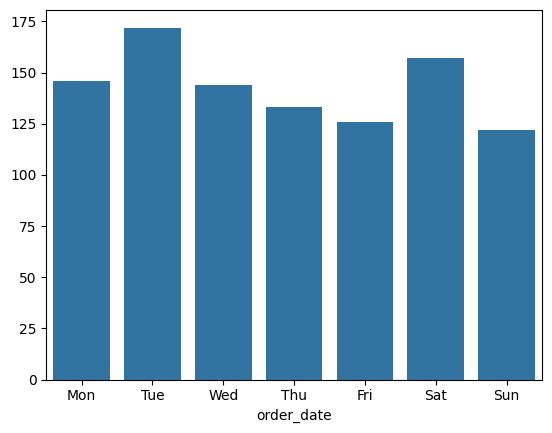

In [ ]:
orders_per_weekday = df.groupby(df.index.dayofweek).size()
sns.barplot(x=orders_per_weekday.index, y=orders_per_weekday.values)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

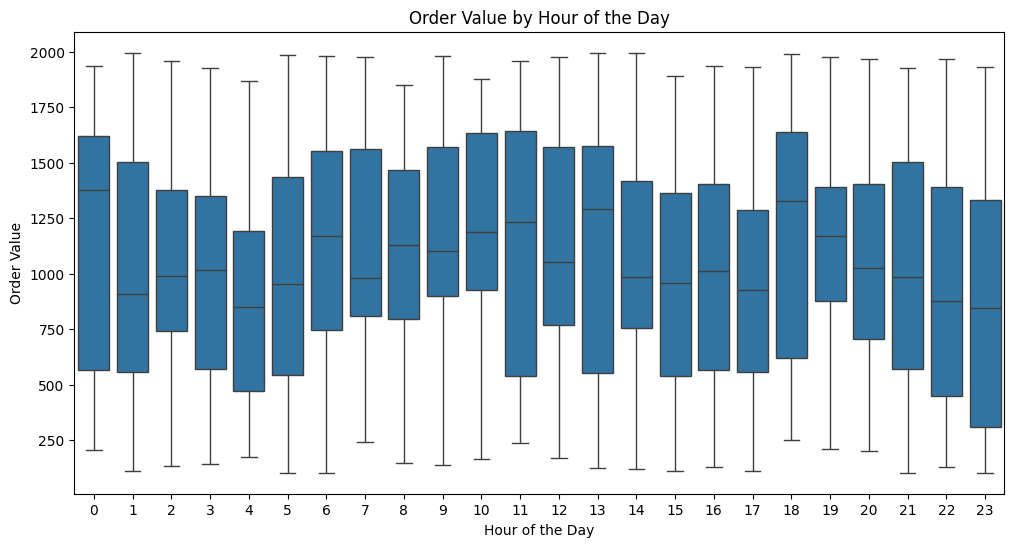

In [ ]:
# 3. effects of different times of the day
plt.figure(figsize=(12, 6))
df['order_hour'] = df['order_date_and_time'].dt.hour
sns.boxplot(x='order_hour', y='order_value', data=df)
plt.title('Order Value by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Order Value')
plt.show()

In [ ]:
breakfast_range = (5, 11)  # 5 AM to 11 AM
lunch_range = (11, 15)     # 11 AM to 3 PM
dinner_range = (15, 20)    # 3 PM to 8 PM
supper_range = (20, 5)     # 8 PM to 5 AM (next day)

# map time of the day
def categorize_time(hour):
    if breakfast_range[0] <= hour < breakfast_range[1]:
        return 'Breakfast'
    elif lunch_range[0] <= hour < lunch_range[1]:
        return 'Lunch'
    elif dinner_range[0] <= hour < dinner_range[1]:
        return 'Dinner'
    else:
        return 'Supper'

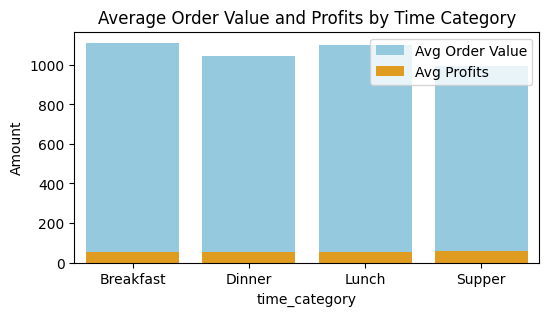

In [ ]:
df['time_category'] = df['order_date_and_time'].dt.hour.apply(categorize_time)
avg_values = df.groupby('time_category').agg({'order_value': 'mean', 'profits': 'mean'}).reset_index()

plt.figure(figsize=(6,3))
sns.barplot(x='time_category', y='order_value', data=avg_values, color='skyblue', label='Avg Order Value')
sns.barplot(x='time_category', y='profits', data=avg_values, color='orange', label='Avg Profits')
plt.title('Average Order Value and Profits by Time Category')
plt.ylabel('Amount')
plt.legend()
plt.show()

These findings guide commercial teams to distribute vouchers and discounts at optimal timings to maximize a chosen performance metric.

<Axes: xlabel='time_category'>

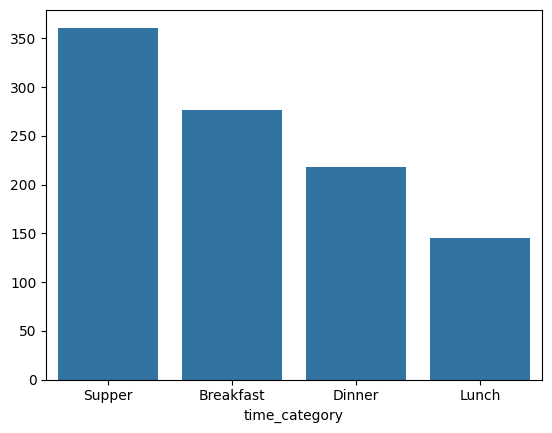

In [ ]:
orders_per_time_category = df['time_category'].value_counts()
sns.barplot(x=orders_per_time_category.index, y=orders_per_time_category.values)